In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [0]:
%pip install fsspec s3fs

  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/44/4b/e0cfc1a6f17e990f3e64b7d941ddc4acdc7b19d6edd51abf495f32b1a9e4/fsspec-2025.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for s3fs from https://files.pythonhosted.org/packages/66/e1/4db0388df5655de92ce5f9b60d2bef220a58dde130e0453e5433c579986e/s3fs-2025.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for aiobotocore<3.0.0,>=2.5.4 from https://files.pythonhosted.org/packages/95/67/026598918f92145156f2feb7957f57daefda20375cc2ac1a0692a9b8010b/aiobotocore-2.21.1-py3-none-any.whl.metadata
  Obtaining dependency information for aiohttp!=4.0.0a0,!=4.0.0a1 from https://files.pythonhosted.org/packages/58/28/3e1e1884070b95f1f69c473a1995852a6f8516670bb1c29d6cb2dbb73e1c/aiohttp-3.11.16-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for aioitertools<1.0.0,>=0.5.1 from https://files.pythonhosted.org/packages/85/13/58b

1. [20 pts] Build any model of your choice with tunable hyperparameters

In [0]:
# Copy from S3 to Databricks DBFS
dbutils.fs.cp("s3://columbia-gr5069-main/raw/lap_times.csv", "file:/tmp/lap_times.csv")
dbutils.fs.cp("s3://columbia-gr5069-main/raw/drivers.csv", "file:/tmp/drivers.csv")
dbutils.fs.cp("s3://columbia-gr5069-main/raw/races.csv", "file:/tmp/races.csv")
dbutils.fs.cp("s3://columbia-gr5069-main/raw/results.csv", "file:/tmp/results.csv")

# Then read using pandas from local path
lap_times = pd.read_csv("/tmp/lap_times.csv")
drivers = pd.read_csv("/tmp/drivers.csv")
races = pd.read_csv("/tmp/races.csv")
results = pd.read_csv("/tmp/results.csv")


In [0]:
# Join and preprocess data
merged = lap_times.merge(races[['raceId', 'year']], on='raceId')
merged = merged.merge(drivers[['driverId', 'surname']], on='driverId')
merged = merged.merge(results[['raceId', 'driverId', 'positionOrder']], on=['raceId', 'driverId'])

grouped = merged.groupby(['driverId', 'surname', 'year']).agg({
    'milliseconds': ['mean', 'std'],
    'lap': 'max',
    'positionOrder': 'mean'
}).reset_index()

grouped.columns = ['driverId', 'surname', 'year', 'mean_ms', 'std_ms', 'max_lap', 'avg_position']
grouped.dropna(inplace=True)

# Encode driver names as numeric
le = LabelEncoder()
grouped['surname_enc'] = le.fit_transform(grouped['surname'])

# Define features and target
X = grouped[['mean_ms', 'std_ms', 'max_lap', 'surname_enc']]
y = grouped['avg_position']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔧 Model with tunable hyperparameters
model = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 9.699739022846149
R² Score: 0.4328212891926726


2. [20 pts] Create an experiment setup where - for each run - you log:

the hyperparameters used in the model
the model itself
every possible metric from the model you chose
at least two artifacts (plots, or csv files)

In [0]:
# Make sure mlflow is available
%pip install mlflow

  Obtaining dependency information for mlflow from https://files.pythonhosted.org/packages/72/f1/be329ef23da1933135afc5e493cbe1b7ecf5302890f2a7ac2124b64c01bd/mlflow-2.21.3-py3-none-any.whl.metadata
  Obtaining dependency information for mlflow-skinny==2.21.3 from https://files.pythonhosted.org/packages/2d/f8/b71f88ca373f248fd7fdf3751f74c7b36a71b7ee2b5f4b803ee053ac963a/mlflow_skinny-2.21.3-py3-none-any.whl.metadata
  Obtaining dependency information for Flask<4 from https://files.pythonhosted.org/packages/af/47/93213ee66ef8fae3b93b3e29206f6b251e65c97bd91d8e1c5596ef15af0a/flask-3.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for Jinja2<4,>=2.11 from https://files.pythonhosted.org/packages/62/a1/3d680cbfd5f4b8f15abc1d571870c5fc3e594bb582bc3b64ea099db13e56/jinja2-3.1.6-py3-none-any.whl.metadata
  Obtaining dependency information for alembic!=1.10.0,<2 from https://files.pythonhosted.org/packages/41/18/d89a443ed1ab9bcda16264716f809c663866d4ca8de218aa78fd50b38ead/alembic-1

2025/04/07 23:40:26 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:40:26 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=100, max_depth=7, MSE=9.70, R²=0.43


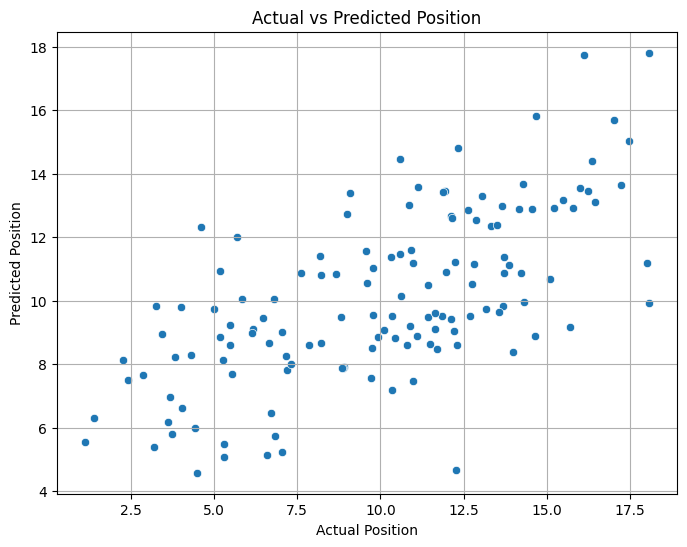

In [0]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os


def run_experiment(n_estimators, max_depth):
    with mlflow.start_run():
        # ⏳ Train model
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # ✅ Log parameters
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # ✅ Log metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2_score", r2)

        # ✅ Log model
        mlflow.sklearn.log_model(model, "random_forest_model")

        # 📊 Artifact 1: Plot actual vs predicted
        plt.figure(figsize=(8,6))
        sns.scatterplot(x=y_test, y=y_pred)
        plt.xlabel("Actual Position")
        plt.ylabel("Predicted Position")
        plt.title("Actual vs Predicted Position")
        plt.grid(True)
        plot_path = "/tmp/actual_vs_predicted.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)

        # 📄 Artifact 2: CSV of predictions
        pred_df = pd.DataFrame({
            "actual": y_test.values,
            "predicted": y_pred
        })
        csv_path = "/tmp/predictions.csv"
        pred_df.to_csv(csv_path, index=False)
        mlflow.log_artifact(csv_path)

        print(f"Run logged with n_estimators={n_estimators}, max_depth={max_depth}, MSE={mse:.2f}, R²={r2:.2f}")
run_experiment(n_estimators=100, max_depth=7)

3. [20 pts] Track your MLFlow experiment and run at least 10 experiments with different parameters each

Running experiment 1 with n_estimators=200, max_depth=10


2025/04/07 23:44:54 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:44:54 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=200, max_depth=10, MSE=9.60, R²=0.44
Running experiment 2 with n_estimators=150, max_depth=3


2025/04/07 23:45:00 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:45:00 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=150, max_depth=3, MSE=11.38, R²=0.33
Running experiment 3 with n_estimators=100, max_depth=10


2025/04/07 23:45:06 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:45:06 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=100, max_depth=10, MSE=9.66, R²=0.44
Running experiment 4 with n_estimators=200, max_depth=5


2025/04/07 23:45:12 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:45:12 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=200, max_depth=5, MSE=10.06, R²=0.41
Running experiment 5 with n_estimators=150, max_depth=10


2025/04/07 23:45:17 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:45:17 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=150, max_depth=10, MSE=9.65, R²=0.44
Running experiment 6 with n_estimators=200, max_depth=10


2025/04/07 23:45:23 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:45:23 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=200, max_depth=10, MSE=9.60, R²=0.44
Running experiment 7 with n_estimators=150, max_depth=5


2025/04/07 23:45:29 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:45:29 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=150, max_depth=5, MSE=10.05, R²=0.41
Running experiment 8 with n_estimators=100, max_depth=7


2025/04/07 23:45:34 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:45:34 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=100, max_depth=7, MSE=9.70, R²=0.43
Running experiment 9 with n_estimators=100, max_depth=5


2025/04/07 23:45:40 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:45:40 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=100, max_depth=5, MSE=10.08, R²=0.41
Running experiment 10 with n_estimators=200, max_depth=10


2025/04/07 23:45:46 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.21.3, required: mlflow==2.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/07 23:45:46 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Run logged with n_estimators=200, max_depth=10, MSE=9.60, R²=0.44


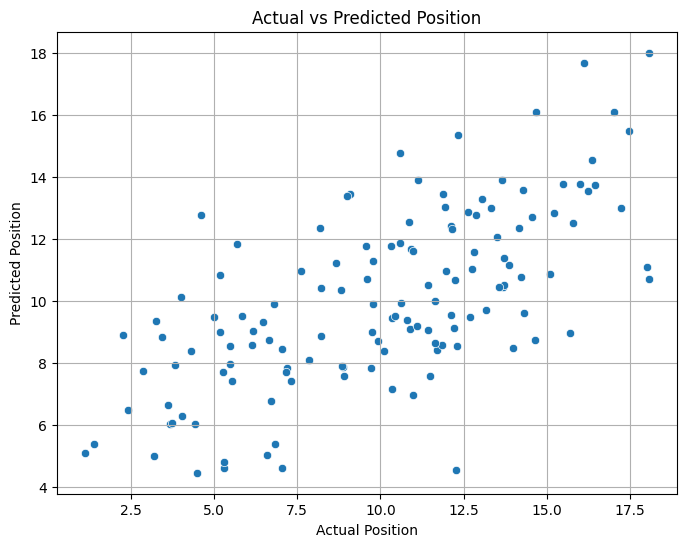

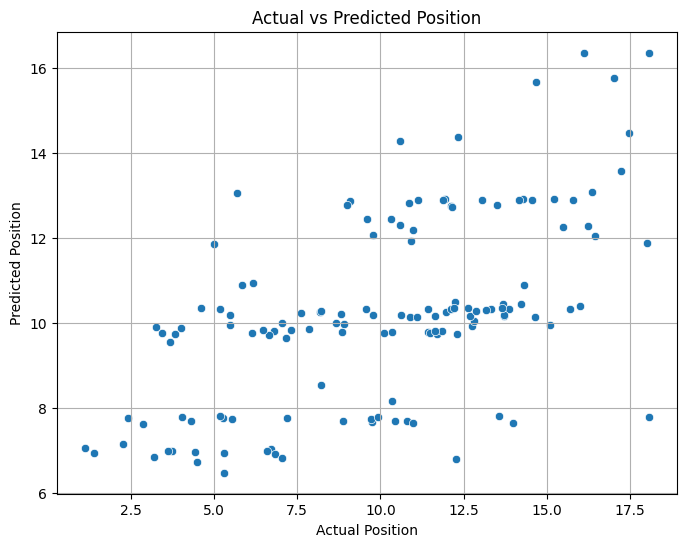

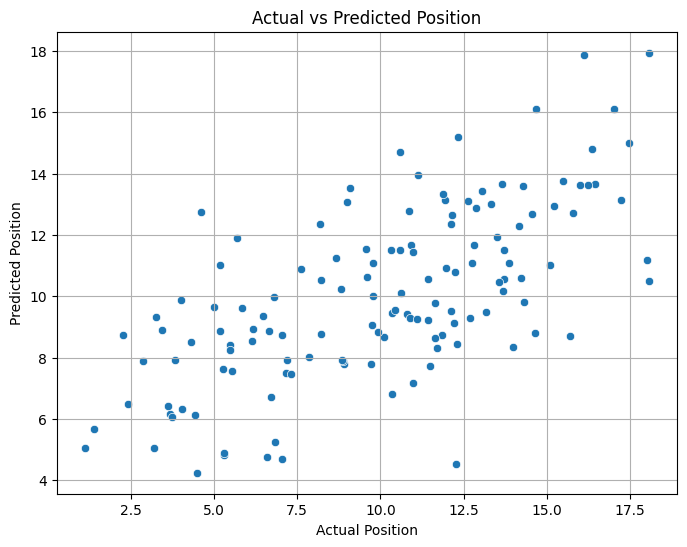

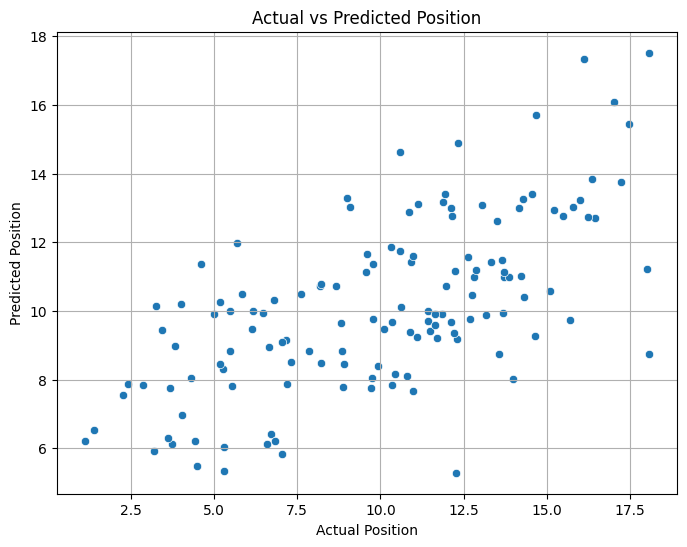

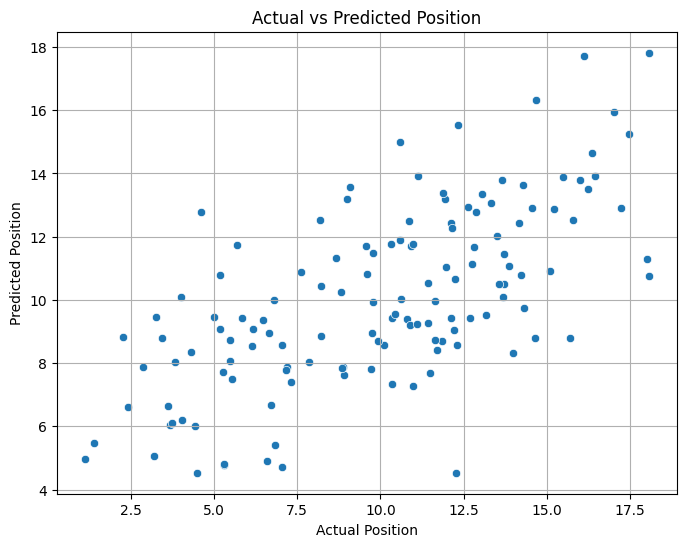

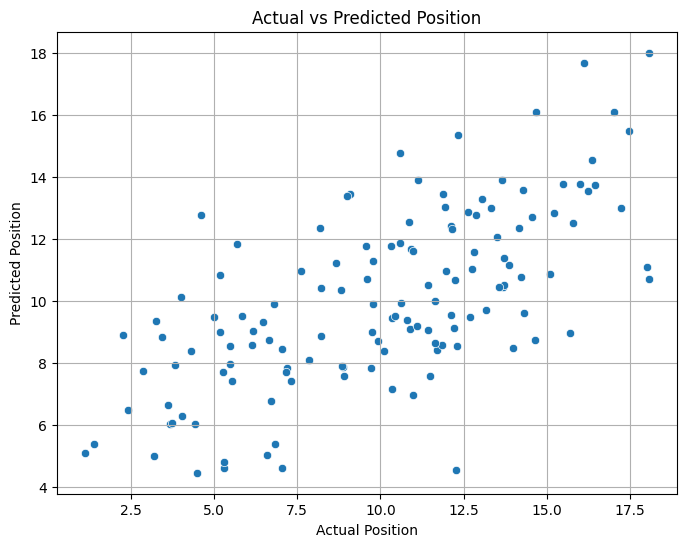

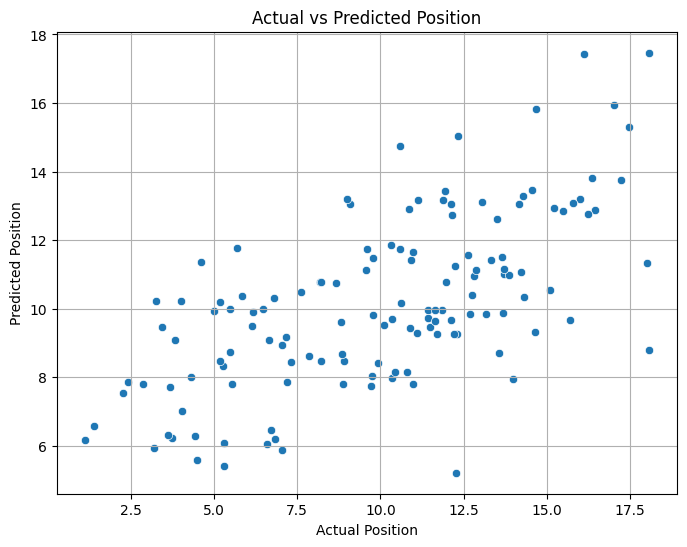

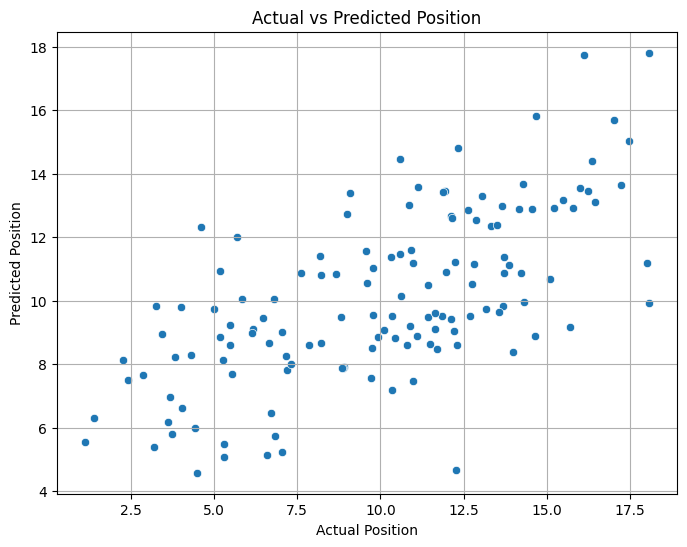

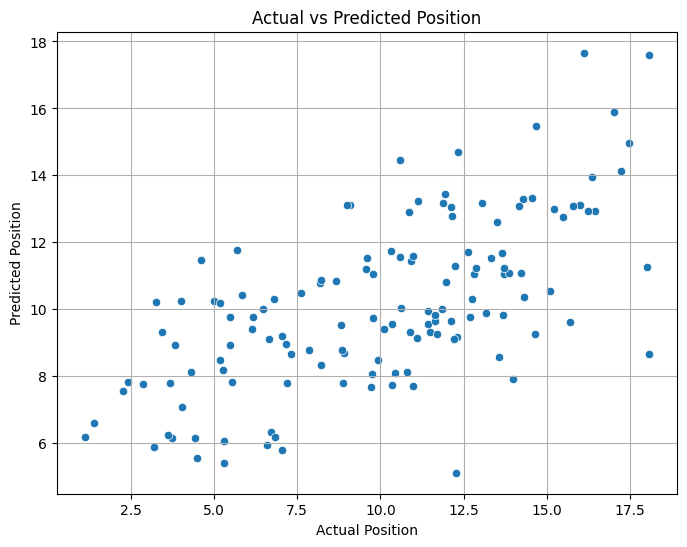

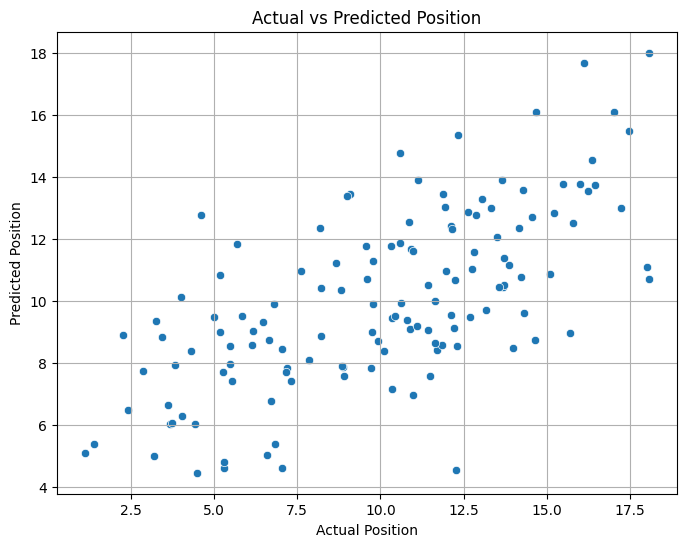

In [0]:
import numpy as np

# Generate and run 10 experiments
for i in range(10):
    n_estimators = np.random.choice([50, 100, 150, 200])
    max_depth = np.random.choice([3, 5, 7, 10, None])  # None means nodes are expanded until all leaves are pure
    print(f"Running experiment {i+1} with n_estimators={n_estimators}, max_depth={max_depth}")
    run_experiment(n_estimators=n_estimators, max_depth=max_depth)


4. [20 pts] Select your best model run and explain why

✅ Best Model Run Explanation
After completing 10 MLflow experiments with varying hyperparameters, I identified the best-performing model based on lowest Mean Squared Error (MSE) and highest R² Score.

Best Run Name: Resilient-mouse-211 (tied with Adorable-shoat-338)

Hyperparameters:

n_estimators: 200

max_depth: 10

Performance Metrics:

Mean Squared Error (MSE): 9.5979
R² Score: 0.4387
This model offered the most reliable predictions across all runs. While the R² score indicates moderate explanatory power, it outperformed other models and best captured the variation in driver race position based on lap time data.

The corresponding Actual vs Predicted plot showed that predictions were reasonably aligned, especially for mid-ranking drivers. The model's performance can likely be improved further with additional features (like weather, pit stops, or qualifying time), but it serves as a solid baseline.

